B-mode images: ['Y:\\Uterine_segmentation\\Auto_segmentation_Xindan_Hu\\Test data\\images\\GREECE44779f5624.jpeg', 'Y:\\Uterine_segmentation\\Auto_segmentation_Xindan_Hu\\Test data\\images\\Italy2103f1172.jpeg', 'Y:\\Uterine_segmentation\\Auto_segmentation_Xindan_Hu\\Test data\\images\\NORM30f1148.jpeg', 'Y:\\Uterine_segmentation\\Auto_segmentation_Xindan_Hu\\Test data\\images\\NORM31f1263.jpeg', 'Y:\\Uterine_segmentation\\Auto_segmentation_Xindan_Hu\\Test data\\images\\OBS20119f4440.jpeg', 'Y:\\Uterine_segmentation\\Auto_segmentation_Xindan_Hu\\Test data\\images\\OBS20223f4906.jpeg', 'Y:\\Uterine_segmentation\\Auto_segmentation_Xindan_Hu\\Test data\\images\\POLI40f3600.jpeg', 'Y:\\Uterine_segmentation\\Auto_segmentation_Xindan_Hu\\Test data\\images\\p155f4275.jpeg', 'Y:\\Uterine_segmentation\\Auto_segmentation_Xindan_Hu\\Test data\\images\\p156f1060.jpeg', 'Y:\\Uterine_segmentation\\Auto_segmentation_Xindan_Hu\\Test data\\images\\p158f8048.jpeg', 'Y:\\Uterine_segmentation\\Auto_segmen

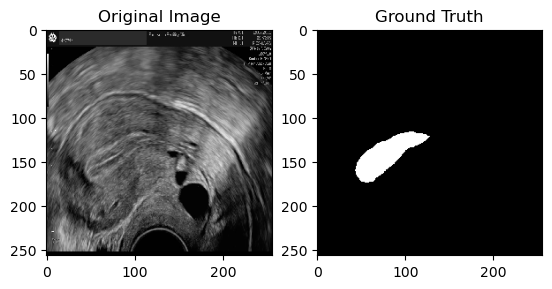

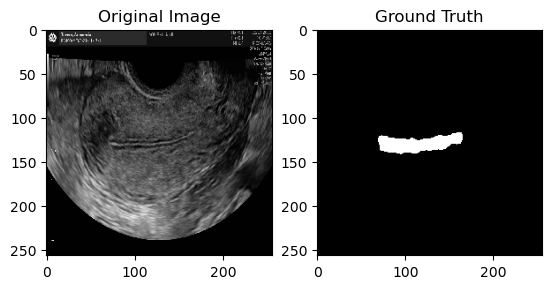

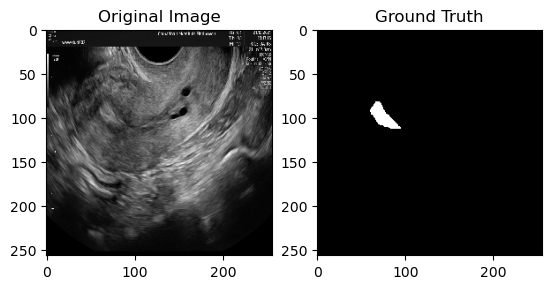

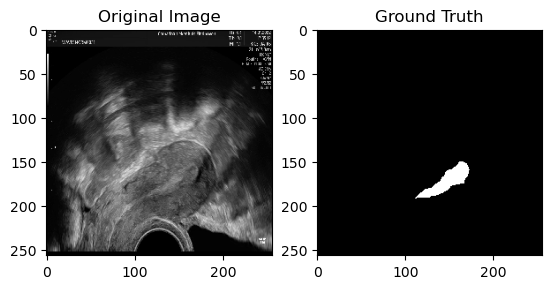

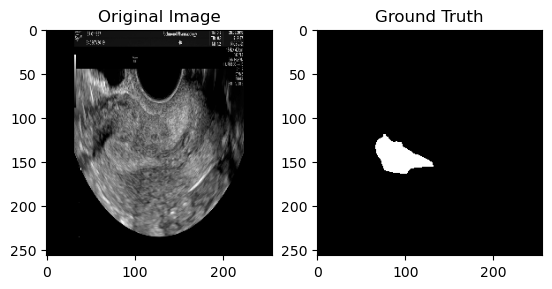

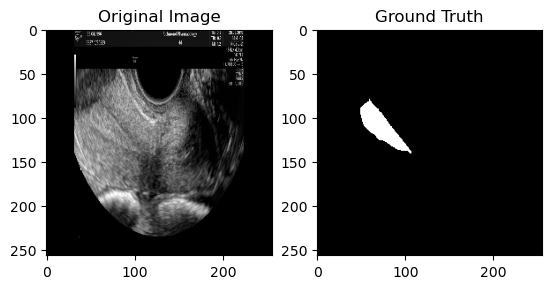

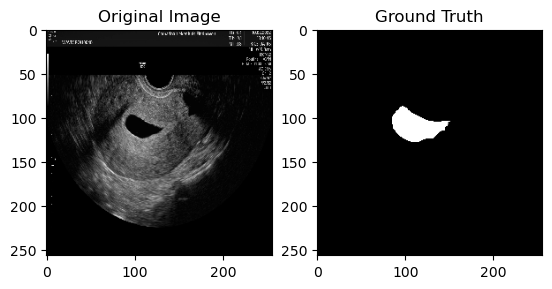

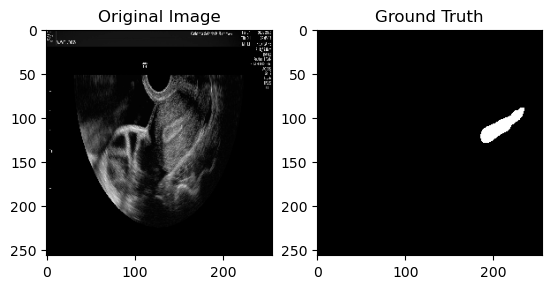

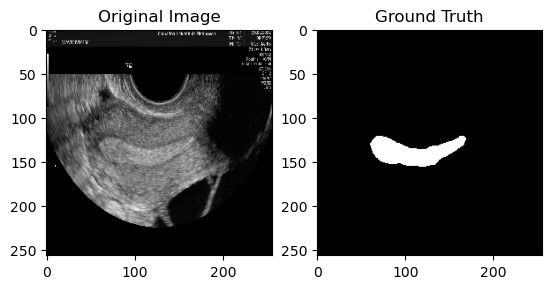

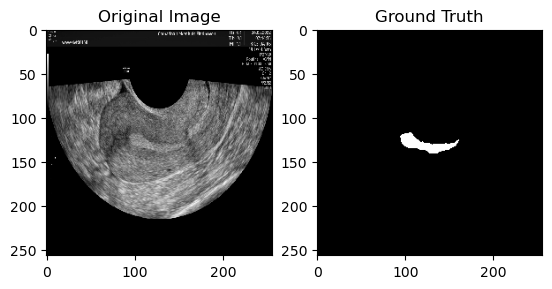

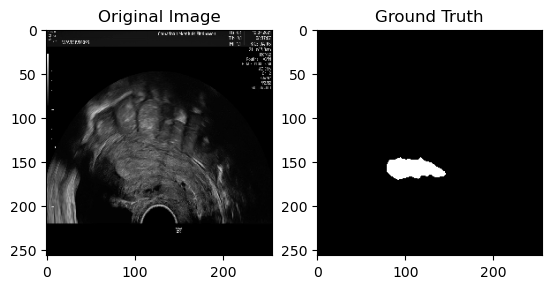

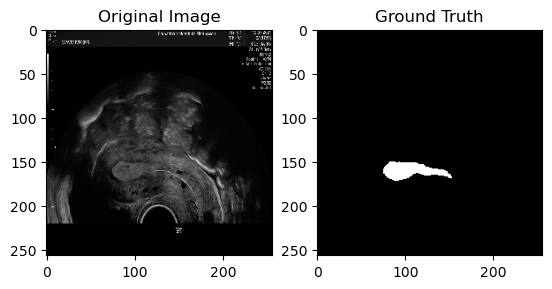

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Unique values in predictions: [0 1]


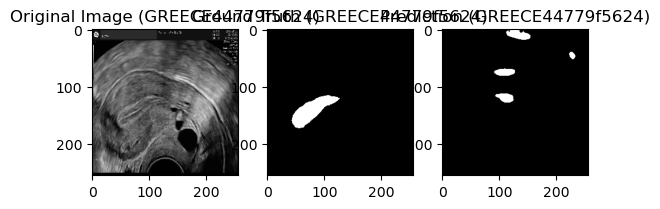

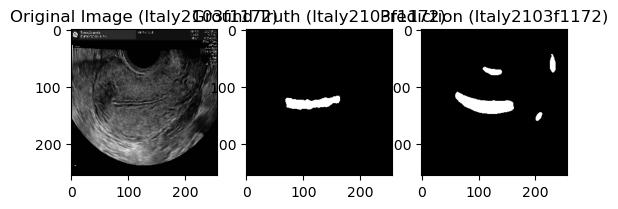

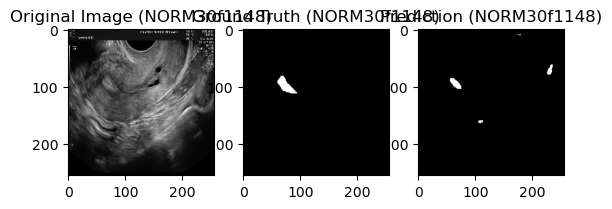

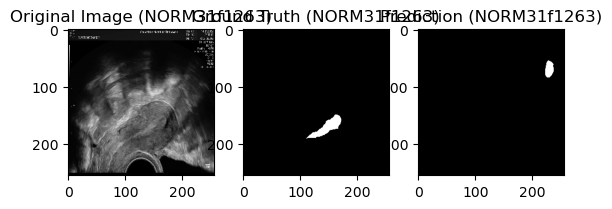

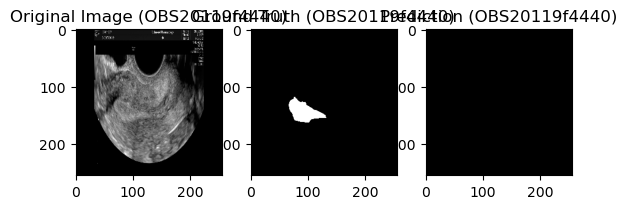

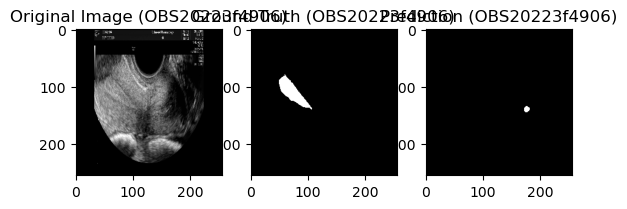

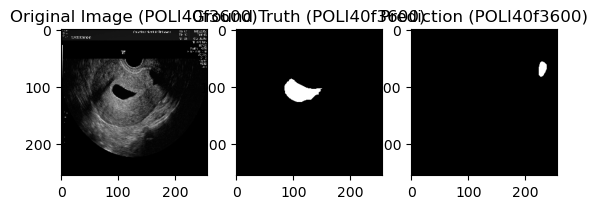

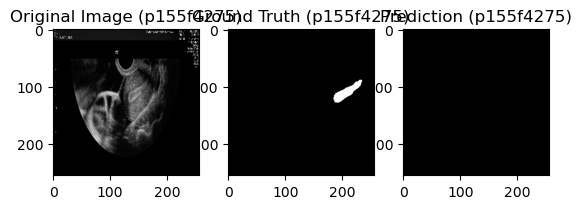

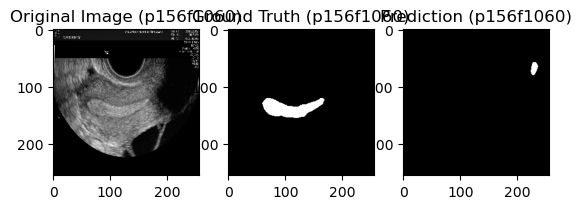

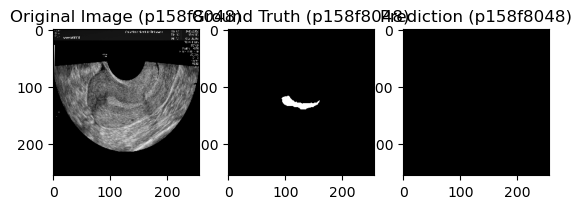

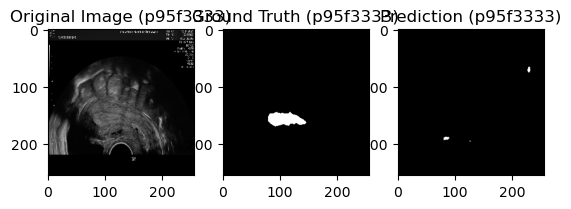

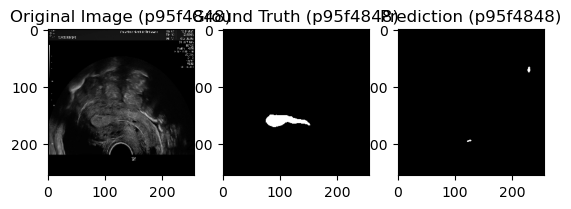

Average IoU: 0.0569
Average Dice: 0.0887
Preprocessed frames and masks saved successfully.


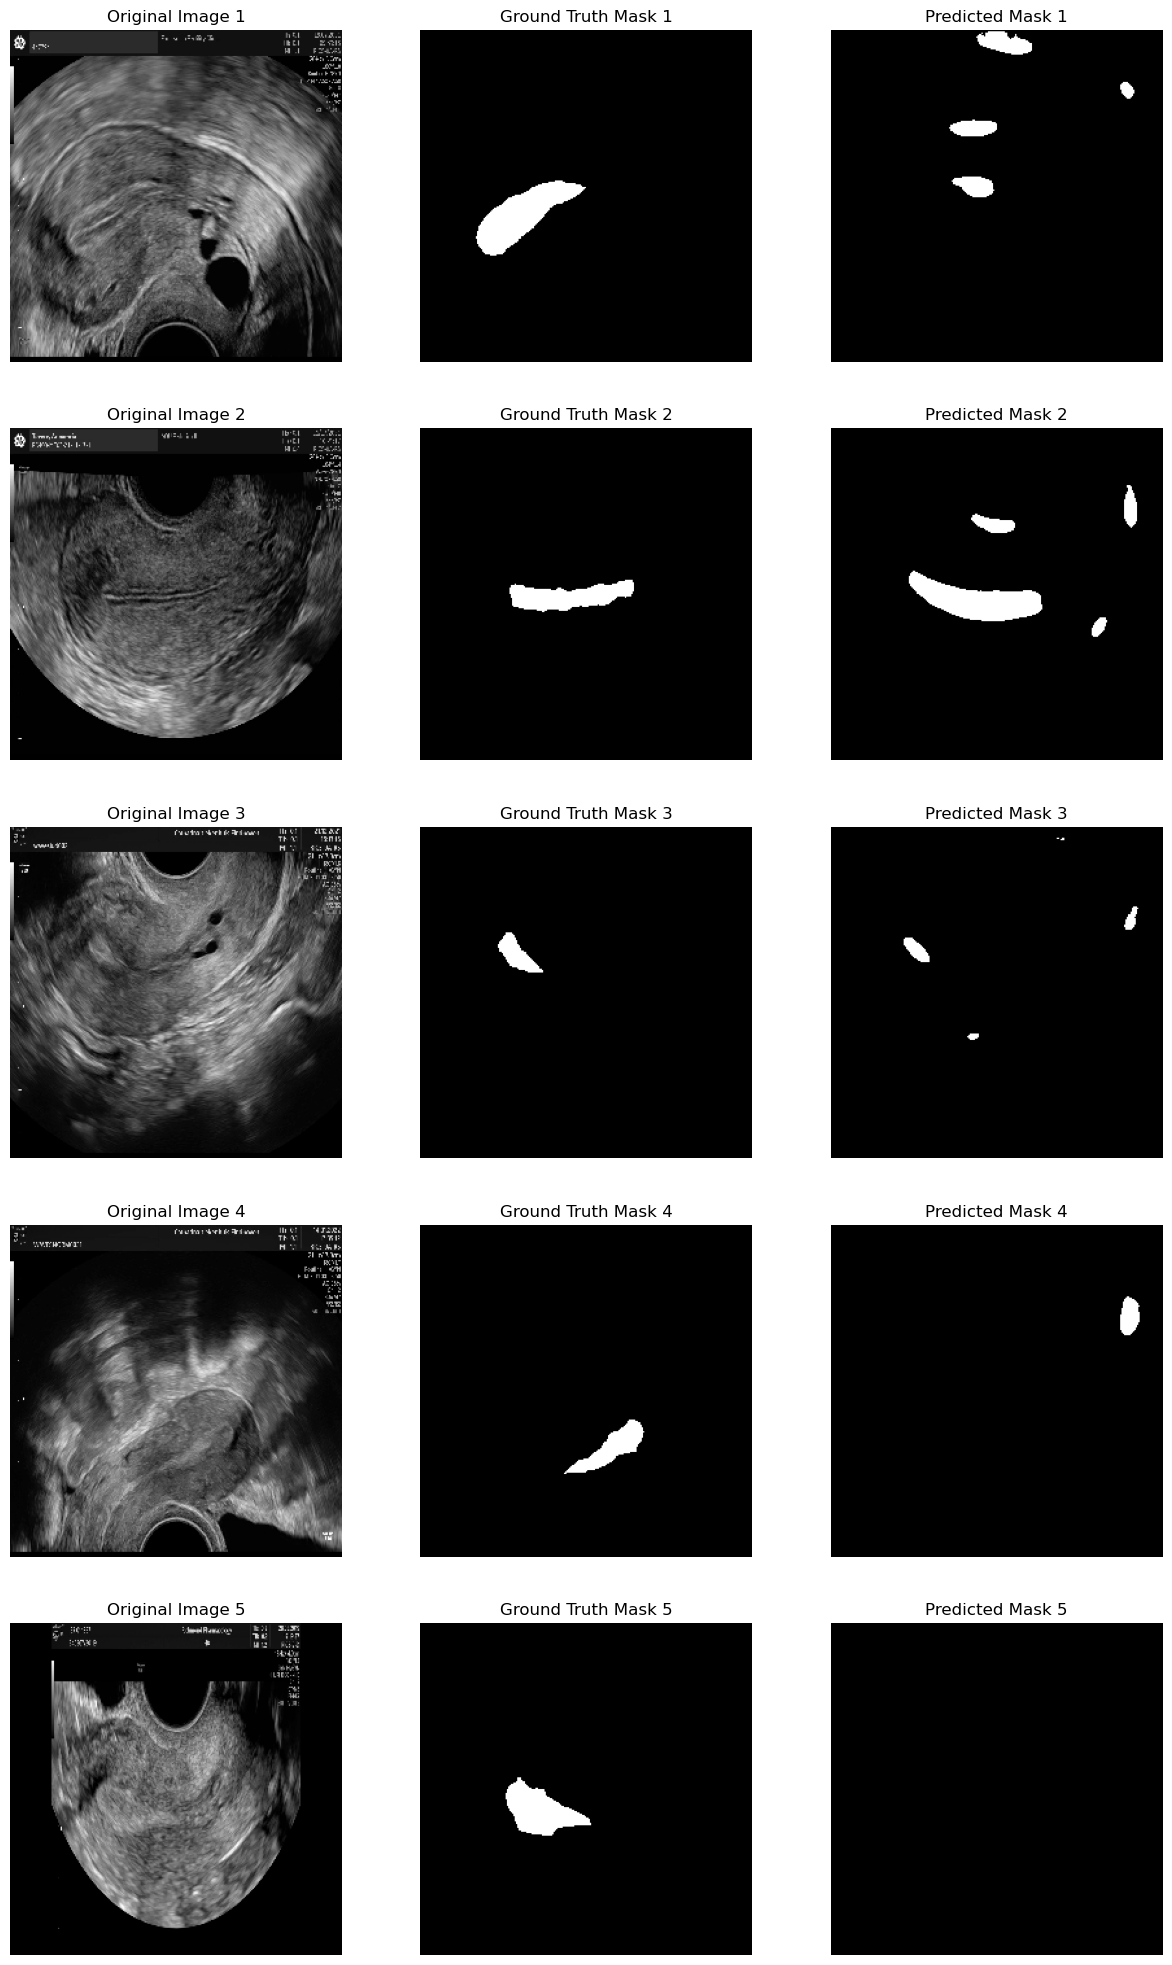

In [4]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, f1_score

# Custom loss function
class CustomBinaryCrossentropy(tf.keras.losses.BinaryCrossentropy):
    def __init__(self, from_logits=False, label_smoothing=0.0, axis=-1, name='binary_crossentropy', **kwargs):
        super().__init__(from_logits=from_logits, label_smoothing=label_smoothing, axis=axis, name=name)

# Register the custom object
tf.keras.utils.get_custom_objects().update({
    'CustomBinaryCrossentropy': CustomBinaryCrossentropy
})

# Paths to the test B-mode images and delineation masks
bmode_images_path = r"Y:\Uterine_segmentation\Auto_segmentation_Xindan_Hu\Test data\images"
delineation_masks_path = r"Y:\Uterine_segmentation\Auto_segmentation_Xindan_Hu\Test data\masks"

# Output folder for saving the processed frames and masks
output_folder = r"Y:\Uterine_segmentation\Auto_segmentation_Mohammad\output of prediction with anyi test data"

# Output subfolders for images and masks
output_images_folder = os.path.join(output_folder, "images")
output_masks_folder = os.path.join(output_folder, "masks")

# Check if network drive is accessible
for path in [bmode_images_path, delineation_masks_path]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Network path not found: {path}. Please check if the network drive is accessible.")

# Create the output folders if they do not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
if not os.path.exists(output_images_folder):
    os.makedirs(output_images_folder)
if not os.path.exists(output_masks_folder):
    os.makedirs(output_masks_folder)

# Function to get all images and masks and ensure proper matching
def get_images_and_masks(image_path, mask_path):
    bmode_images = sorted([os.path.join(image_path, f) for f in os.listdir(image_path) if f.endswith('.jpeg')])
    delineation_masks = sorted([os.path.join(mask_path, f) for f in os.listdir(mask_path) if f.endswith('.jpeg')])

    if len(bmode_images) != len(delineation_masks):
        raise ValueError("The number of images and masks should be the same.")

    all_filenames = [os.path.basename(f).replace('.jpeg', '') for f in bmode_images]

    return bmode_images, delineation_masks, all_filenames

# Get matched images and masks with filenames
bmode_images, delineation_masks, filenames = get_images_and_masks(bmode_images_path, delineation_masks_path)

# Print sampled image paths and filenames for debugging
print("B-mode images:", bmode_images)
print("Delineation masks:", delineation_masks)
print("Filenames:", filenames)

# Function to load images and masks
def load_images_and_masks(img_paths, mask_paths, target_size=(256, 256)):
    images = []
    masks = []
    for img_path, mask_path in zip(img_paths, mask_paths):
        img = load_img(img_path, target_size=target_size)
        img = img.convert('L')  # Convert RGB to grayscale
        img = img_to_array(img) / 255.0  # Normalize to [0, 1]

        mask = load_img(mask_path, target_size=target_size, color_mode="grayscale")
        mask = img_to_array(mask) / 255.0  # Normalize to [0, 1]

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load the images and masks
images, masks = load_images_and_masks(bmode_images, delineation_masks)

# Print shapes of loaded images and masks for debugging
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

# Check for empty arrays
if images.size == 0 or masks.size == 0:
    raise ValueError("Loaded images or masks array is empty. Please check the paths and ensure there are images in the specified directories.")

# Function to perform prediction
def predict(model, test_images):
    predictions = model.predict(test_images)
    return predictions

# Normalize images and masks
def min_max_normalize(X, Y):
    if X.size == 0 or Y.size == 0:
        raise ValueError("Input arrays are empty. Cannot normalize.")
    X = (X - np.min(X)) / (np.max(X) - np.min(X))
    Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y))
    Y = (Y > 0.5).astype(np.bool_)
    return X, Y

# Calculate metrics: IoU and Dice coefficient
def calculate_metrics(predictions, ground_truth):
    predictions_bin = (predictions > 0.5).astype(np.uint8).flatten()
    ground_truth_bin = (ground_truth > 0.5).astype(np.uint8).flatten()
    iou = jaccard_score(ground_truth_bin, predictions_bin, average='binary')
    dice = f1_score(ground_truth_bin, predictions_bin, average='binary')
    return iou, dice

# Function to display images and their corresponding masks
def display_images_with_masks(images, masks, predictions, n=5):
    plt.figure(figsize=(15, n * 5))
    for i in range(n):
        # Original image
        plt.subplot(n, 3, i * 3 + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Original Image {i+1}")
        plt.axis("off")
        
        # Ground truth mask
        plt.subplot(n, 3, i * 3 + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title(f"Ground Truth Mask {i+1}")
        plt.axis("off")
        
        # Predicted mask
        plt.subplot(n, 3, i * 3 + 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title(f"Predicted Mask {i+1}")
        plt.axis("off")
        
    plt.show()

if __name__ == "__main__":
    # Preprocess test images and masks
    test_images, test_masks = images, masks

    # Check for empty arrays
    if test_images.size == 0 or test_masks.size == 0:
        raise ValueError("Preprocessed images or masks array is empty. Please check the preprocessing steps.")

    # Normalize images and masks
    test_images, test_masks = min_max_normalize(test_images, test_masks)

    # Visualize test images and masks
    for i in range(len(test_images)):
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(test_images[i].squeeze(), cmap='gray')
        plt.subplot(1, 2, 2)
        plt.title('Ground Truth')
        plt.imshow(test_masks[i].squeeze(), cmap='gray')
        plt.show()

    # Load the trained model without compiling
    model_path = r'Y:\Uterine_segmentation\Auto_segmentation_Mohammad\unet_model.h5'
    model = load_model(model_path, compile=False, custom_objects={'CustomBinaryCrossentropy': CustomBinaryCrossentropy})

    # Compile the model again with the custom loss function
    model.compile(optimizer='adam', loss=CustomBinaryCrossentropy(), metrics=['accuracy'])

    # Perform prediction
    predictions = predict(model, test_images)

    # Threshold the predictions
    predictions = (predictions > 0.5).astype(np.uint8)

    # Print unique values in predictions to check if it's predicting correctly
    print("Unique values in predictions:", np.unique(predictions))

    # Show predictions with filenames
    for i in range(len(predictions)):
        plt.figure()
        plt.subplot(1, 3, 1)
        plt.title(f'Original Image ({filenames[i]})')
        plt.imshow(test_images[i].squeeze(), cmap='gray')
        plt.subplot(1, 3, 2)
        plt.title(f'Ground Truth ({filenames[i]})')
        plt.imshow(test_masks[i].squeeze(), cmap='gray')
        plt.subplot(1, 3, 3)
        plt.title(f'Prediction ({filenames[i]})')
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.show()

    iou_scores = []
    dice_scores = []

    # Convert predictions to binary masks
    predicted_masks = (predictions > 0.5).astype(np.uint8)

    for i in range(len(test_masks)):
        iou, dice = calculate_metrics(predicted_masks[i], test_masks[i])
        iou_scores.append(iou)
        dice_scores.append(dice)

    # Print average IoU and Dice scores
    print(f"Average IoU: {np.mean(iou_scores):.4f}")
    print(f"Average Dice: {np.mean(dice_scores):.4f}")

    # Save the preprocessed frames and masks as images in separate folders
    for i, (frame, mask) in enumerate(zip(test_images, predicted_masks)):
        # Save preprocessed frame
        frame_image = Image.fromarray((frame * 255).astype(np.uint8).squeeze(), mode='L')  # Convert back to uint8 for saving
        frame_filename = f'{filenames[i]}_preprocessed.jpg'
        frame_image.save(os.path.join(output_images_folder, frame_filename))
        
        # Save mask
        mask_image = Image.fromarray((mask * 255).astype(np.uint8).squeeze(), mode='L')  # mode='L' for grayscale
        mask_filename = f'{filenames[i]}_mask.jpg'
        mask_image.save(os.path.join(output_masks_folder, mask_filename))

    print("Preprocessed frames and masks saved successfully.")

    # Display the images with their ground truth and predicted masks
    display_images_with_masks(test_images, test_masks, predicted_masks, n=5)


B-mode images: ['Y:\\Uterine_segmentation\\Auto_segmentation_Xindan_Hu\\Test data\\images\\GREECE44779f5624.jpeg', 'Y:\\Uterine_segmentation\\Auto_segmentation_Xindan_Hu\\Test data\\images\\Italy2103f1172.jpeg', 'Y:\\Uterine_segmentation\\Auto_segmentation_Xindan_Hu\\Test data\\images\\NORM30f1148.jpeg', 'Y:\\Uterine_segmentation\\Auto_segmentation_Xindan_Hu\\Test data\\images\\NORM31f1263.jpeg', 'Y:\\Uterine_segmentation\\Auto_segmentation_Xindan_Hu\\Test data\\images\\OBS20119f4440.jpeg', 'Y:\\Uterine_segmentation\\Auto_segmentation_Xindan_Hu\\Test data\\images\\OBS20223f4906.jpeg', 'Y:\\Uterine_segmentation\\Auto_segmentation_Xindan_Hu\\Test data\\images\\POLI40f3600.jpeg', 'Y:\\Uterine_segmentation\\Auto_segmentation_Xindan_Hu\\Test data\\images\\p155f4275.jpeg', 'Y:\\Uterine_segmentation\\Auto_segmentation_Xindan_Hu\\Test data\\images\\p156f1060.jpeg', 'Y:\\Uterine_segmentation\\Auto_segmentation_Xindan_Hu\\Test data\\images\\p158f8048.jpeg', 'Y:\\Uterine_segmentation\\Auto_segmen

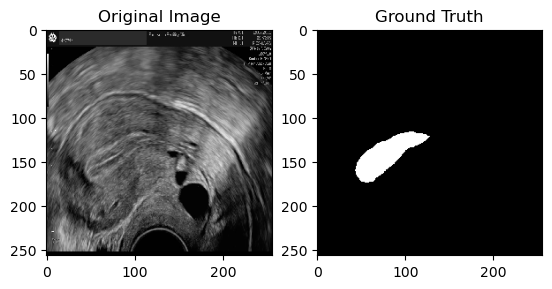

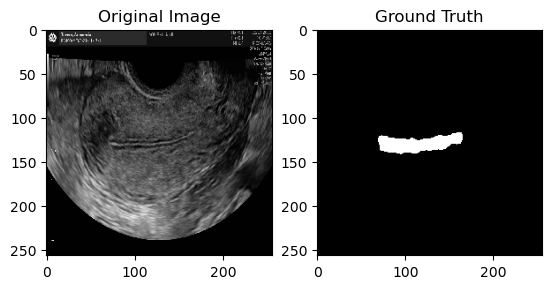

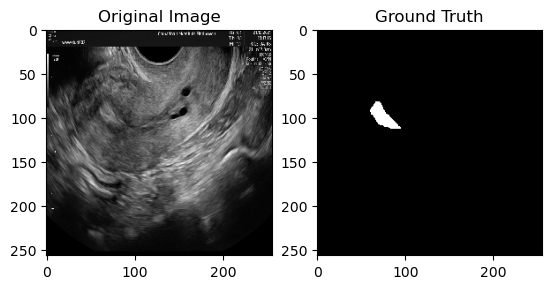

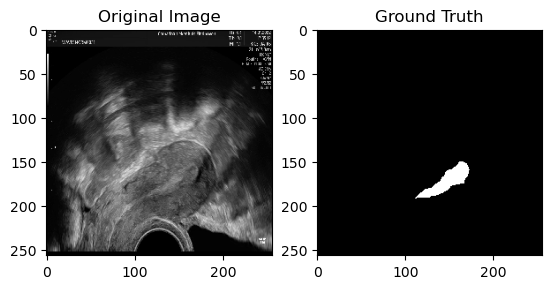

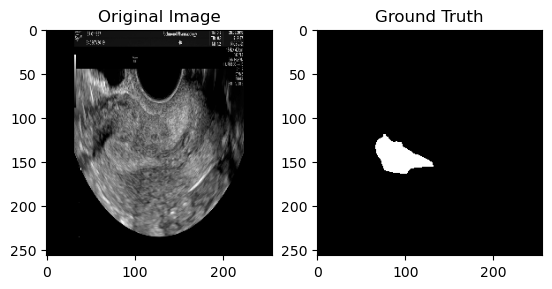

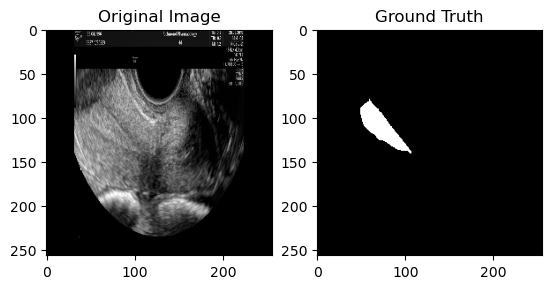

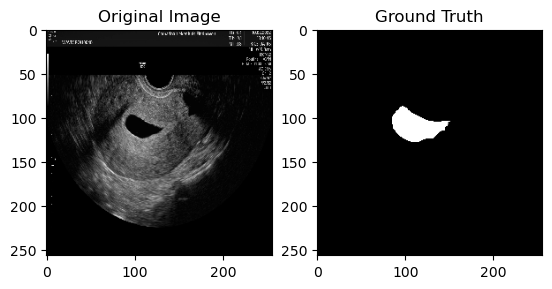

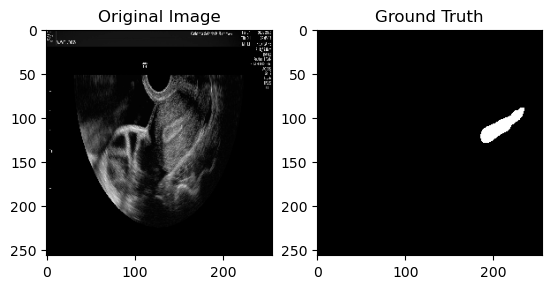

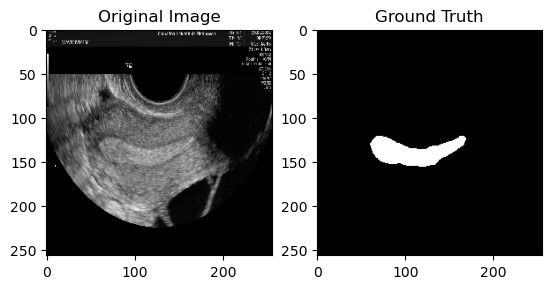

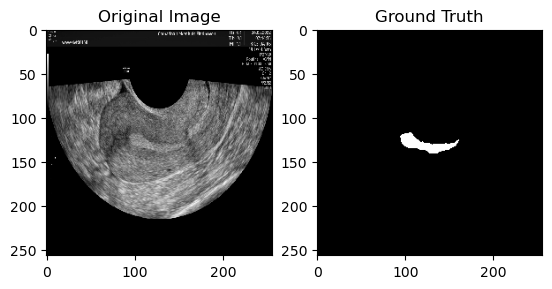

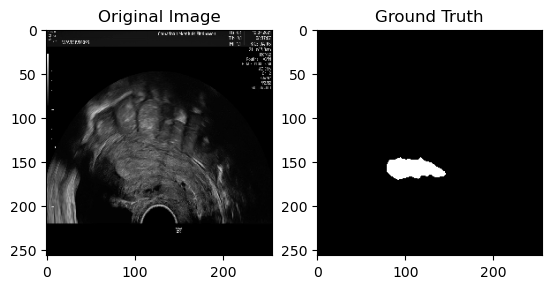

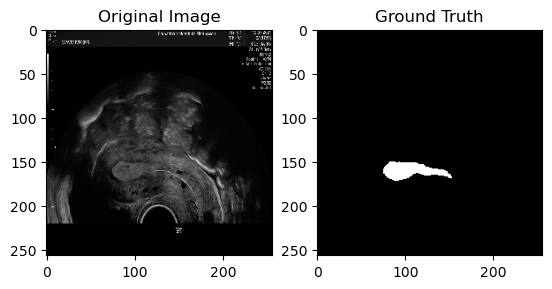

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Unique values in predictions: [0 1]


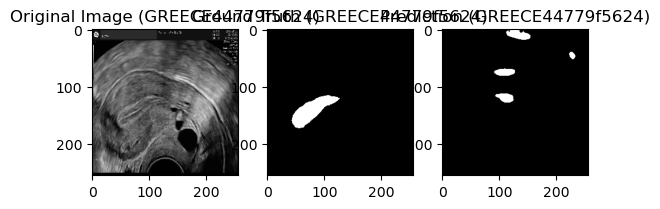

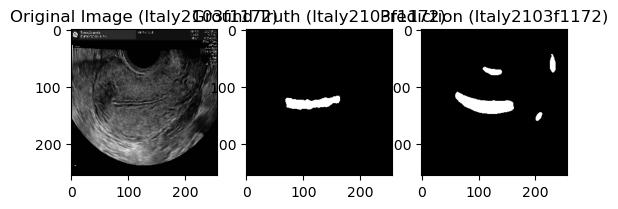

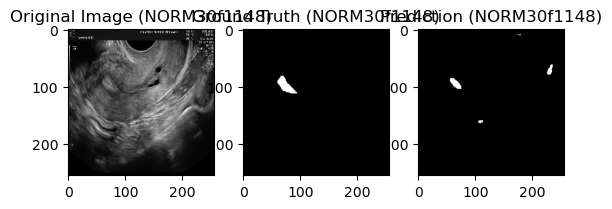

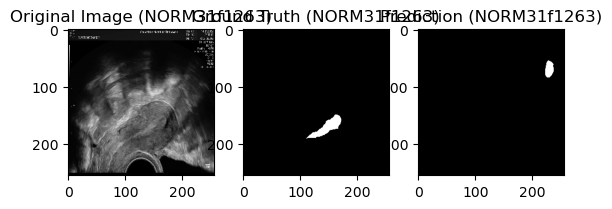

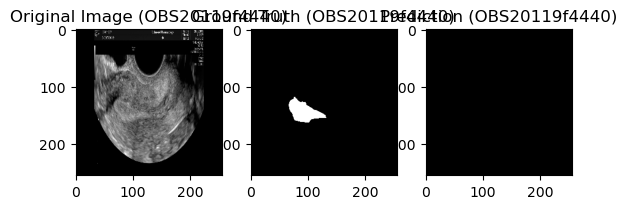

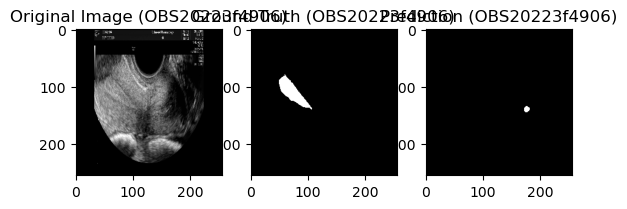

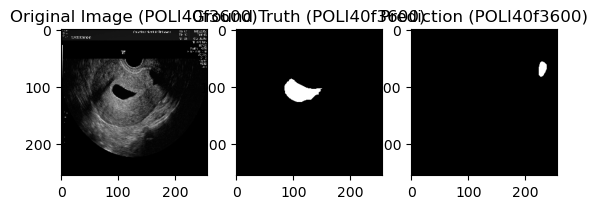

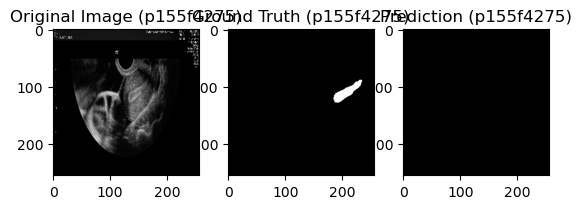

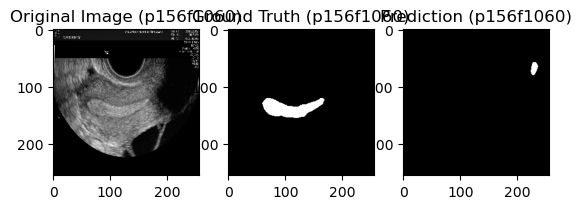

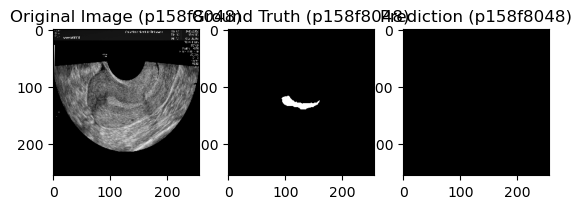

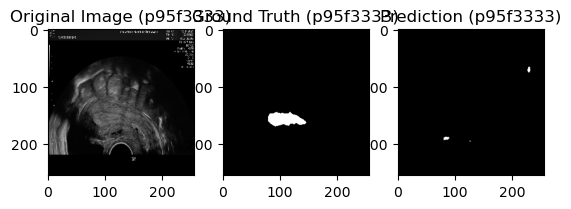

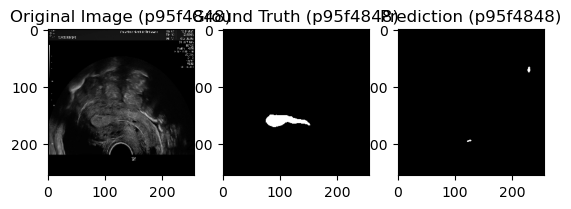

Average IoU: 0.0569
Average Dice: 0.0887
Preprocessed frames and masks saved successfully.


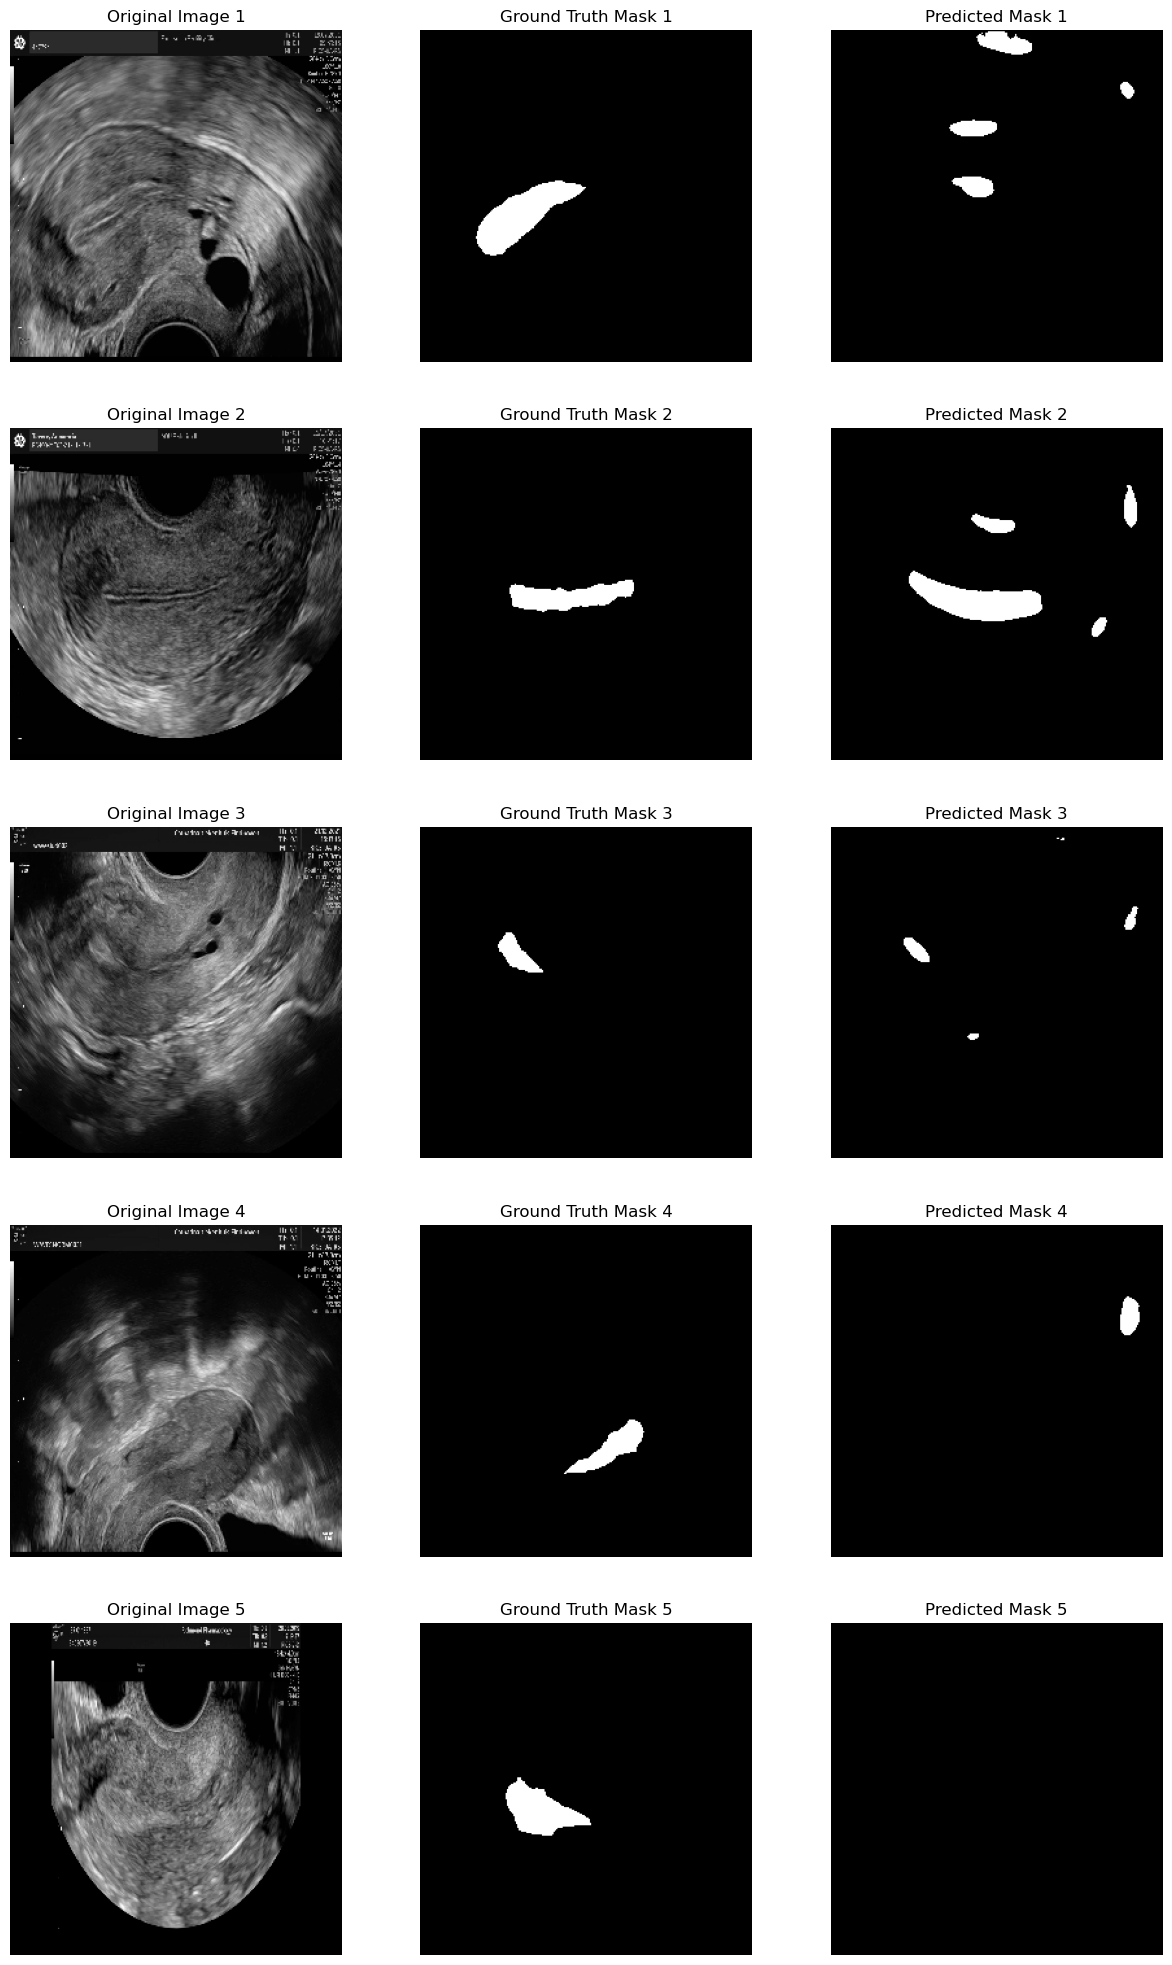

In [5]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, f1_score

# Custom loss function
class CustomBinaryCrossentropy(tf.keras.losses.BinaryCrossentropy):
    def __init__(self, from_logits=False, label_smoothing=0.0, axis=-1, name='binary_crossentropy', **kwargs):
        super().__init__(from_logits=from_logits, label_smoothing=label_smoothing, axis=axis, name=name)

# Register the custom object
tf.keras.utils.get_custom_objects().update({
    'CustomBinaryCrossentropy': CustomBinaryCrossentropy
})

# Paths to the test B-mode images and delineation masks
bmode_images_path = r"Y:\Uterine_segmentation\Auto_segmentation_Xindan_Hu\Test data\images"
delineation_masks_path = r"Y:\Uterine_segmentation\Auto_segmentation_Xindan_Hu\Test data\masks"

# Output folder for saving the processed frames and masks
output_folder = r"Y:\Uterine_segmentation\Auto_segmentation_Mohammad\output of prediction with anyi test data"

# Output subfolders for images and masks
output_images_folder = os.path.join(output_folder, "images")
output_masks_folder = os.path.join(output_folder, "masks")

# Check if network drive is accessible
for path in [bmode_images_path, delineation_masks_path]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Network path not found: {path}. Please check if the network drive is accessible.")

# Create the output folders if they do not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
if not os.path.exists(output_images_folder):
    os.makedirs(output_images_folder)
if not os.path.exists(output_masks_folder):
    os.makedirs(output_masks_folder)

# Function to get all images and masks and ensure proper matching
def get_images_and_masks(image_path, mask_path):
    bmode_images = sorted([os.path.join(image_path, f) for f in os.listdir(image_path) if f.endswith('.jpeg')])
    delineation_masks = sorted([os.path.join(mask_path, f) for f in os.listdir(mask_path) if f.endswith('.jpeg')])

    if len(bmode_images) != len(delineation_masks):
        raise ValueError("The number of images and masks should be the same.")

    all_filenames = [os.path.basename(f).replace('.jpeg', '') for f in bmode_images]

    return bmode_images, delineation_masks, all_filenames

# Get matched images and masks with filenames
bmode_images, delineation_masks, filenames = get_images_and_masks(bmode_images_path, delineation_masks_path)

# Print sampled image paths and filenames for debugging
print("B-mode images:", bmode_images)
print("Delineation masks:", delineation_masks)
print("Filenames:", filenames)

# Function to load images and masks
def load_images_and_masks(img_paths, mask_paths, target_size=(256, 256)):
    images = []
    masks = []
    for img_path, mask_path in zip(img_paths, mask_paths):
        img = load_img(img_path, target_size=target_size)
        img = img.convert('L')  # Convert RGB to grayscale
        img = img_to_array(img) / 255.0  # Normalize to [0, 1]

        mask = load_img(mask_path, target_size=target_size, color_mode="grayscale")
        mask = img_to_array(mask) / 255.0  # Normalize to [0, 1]

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load the images and masks
images, masks = load_images_and_masks(bmode_images, delineation_masks)

# Print shapes of loaded images and masks for debugging
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

# Check for empty arrays
if images.size == 0 or masks.size == 0:
    raise ValueError("Loaded images or masks array is empty. Please check the paths and ensure there are images in the specified directories.")

# Function to perform prediction
def predict(model, test_images):
    predictions = model.predict(test_images)
    return predictions

# Normalize images and masks
def min_max_normalize(X, Y):
    if X.size == 0 or Y.size == 0:
        raise ValueError("Input arrays are empty. Cannot normalize.")
    X = (X - np.min(X)) / (np.max(X) - np.min(X))
    Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y))
    Y = (Y > 0.5).astype(np.bool_)
    return X, Y

# Calculate metrics: IoU and Dice coefficient
def calculate_metrics(predictions, ground_truth):
    predictions_bin = (predictions > 0.5).astype(np.uint8).flatten()
    ground_truth_bin = (ground_truth > 0.5).astype(np.uint8).flatten()
    iou = jaccard_score(ground_truth_bin, predictions_bin, average='binary')
    dice = f1_score(ground_truth_bin, predictions_bin, average='binary')
    return iou, dice

# Function to display images and their corresponding masks
def display_images_with_masks(images, masks, predictions, n=5):
    plt.figure(figsize=(15, n * 5))
    for i in range(n):
        # Original image
        plt.subplot(n, 3, i * 3 + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Original Image {i+1}")
        plt.axis("off")
        
        # Ground truth mask
        plt.subplot(n, 3, i * 3 + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title(f"Ground Truth Mask {i+1}")
        plt.axis("off")
        
        # Predicted mask
        plt.subplot(n, 3, i * 3 + 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title(f"Predicted Mask {i+1}")
        plt.axis("off")
        
    plt.show()

if __name__ == "__main__":
    # Preprocess test images and masks
    test_images, test_masks = images, masks

    # Check for empty arrays
    if test_images.size == 0 or test_masks.size == 0:
        raise ValueError("Preprocessed images or masks array is empty. Please check the preprocessing steps.")

    # Normalize images and masks
    test_images, test_masks = min_max_normalize(test_images, test_masks)

    # Visualize test images and masks
    for i in range(len(test_images)):
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(test_images[i].squeeze(), cmap='gray')
        plt.subplot(1, 2, 2)
        plt.title('Ground Truth')
        plt.imshow(test_masks[i].squeeze(), cmap='gray')
        plt.show()

    # Load the trained model without compiling
    model_path = r'Y:\Uterine_segmentation\Auto_segmentation_Mohammad\unet_model.h5'
    model = load_model(model_path, compile=False, custom_objects={'CustomBinaryCrossentropy': CustomBinaryCrossentropy})

    # Compile the model again with the custom loss function
    model.compile(optimizer='adam', loss=CustomBinaryCrossentropy(), metrics=['accuracy'])

    # Perform prediction
    predictions = predict(model, test_images)

    # Threshold the predictions
    predictions = (predictions > 0.5).astype(np.uint8)

    # Print unique values in predictions to check if it's predicting correctly
    print("Unique values in predictions:", np.unique(predictions))

    # Show predictions with filenames
    for i in range(len(predictions)):
        plt.figure()
        plt.subplot(1, 3, 1)
        plt.title(f'Original Image ({filenames[i]})')
        plt.imshow(test_images[i].squeeze(), cmap='gray')
        plt.subplot(1, 3, 2)
        plt.title(f'Ground Truth ({filenames[i]})')
        plt.imshow(test_masks[i].squeeze(), cmap='gray')
        plt.subplot(1, 3, 3)
        plt.title(f'Prediction ({filenames[i]})')
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.show()

    iou_scores = []
    dice_scores = []

    # Convert predictions to binary masks
    predicted_masks = (predictions > 0.5).astype(np.uint8)

    for i in range(len(test_masks)):
        iou, dice = calculate_metrics(predicted_masks[i], test_masks[i])
        iou_scores.append(iou)
        dice_scores.append(dice)

    # Print average IoU and Dice scores
    print(f"Average IoU: {np.mean(iou_scores):.4f}")
    print(f"Average Dice: {np.mean(dice_scores):.4f}")

    # Save the preprocessed frames and masks as images in separate folders
    for i, (frame, mask) in enumerate(zip(test_images, predicted_masks)):
        # Save preprocessed frame
        frame_image = Image.fromarray((frame * 255).astype(np.uint8).squeeze(), mode='L')  # Convert back to uint8 for saving
        frame_filename = f'{filenames[i]}_preprocessed.jpg'
        frame_image.save(os.path.join(output_images_folder, frame_filename))
        
        # Save mask
        mask_image = Image.fromarray((mask * 255).astype(np.uint8).squeeze(), mode='L')  # mode='L' for grayscale
        mask_filename = f'{filenames[i]}_mask.jpg'
        mask_image.save(os.path.join(output_masks_folder, mask_filename))

    print("Preprocessed frames and masks saved successfully.")

    # Display the images with their ground truth and predicted masks
    display_images_with_masks(test_images, test_masks, predicted_masks, n=5)


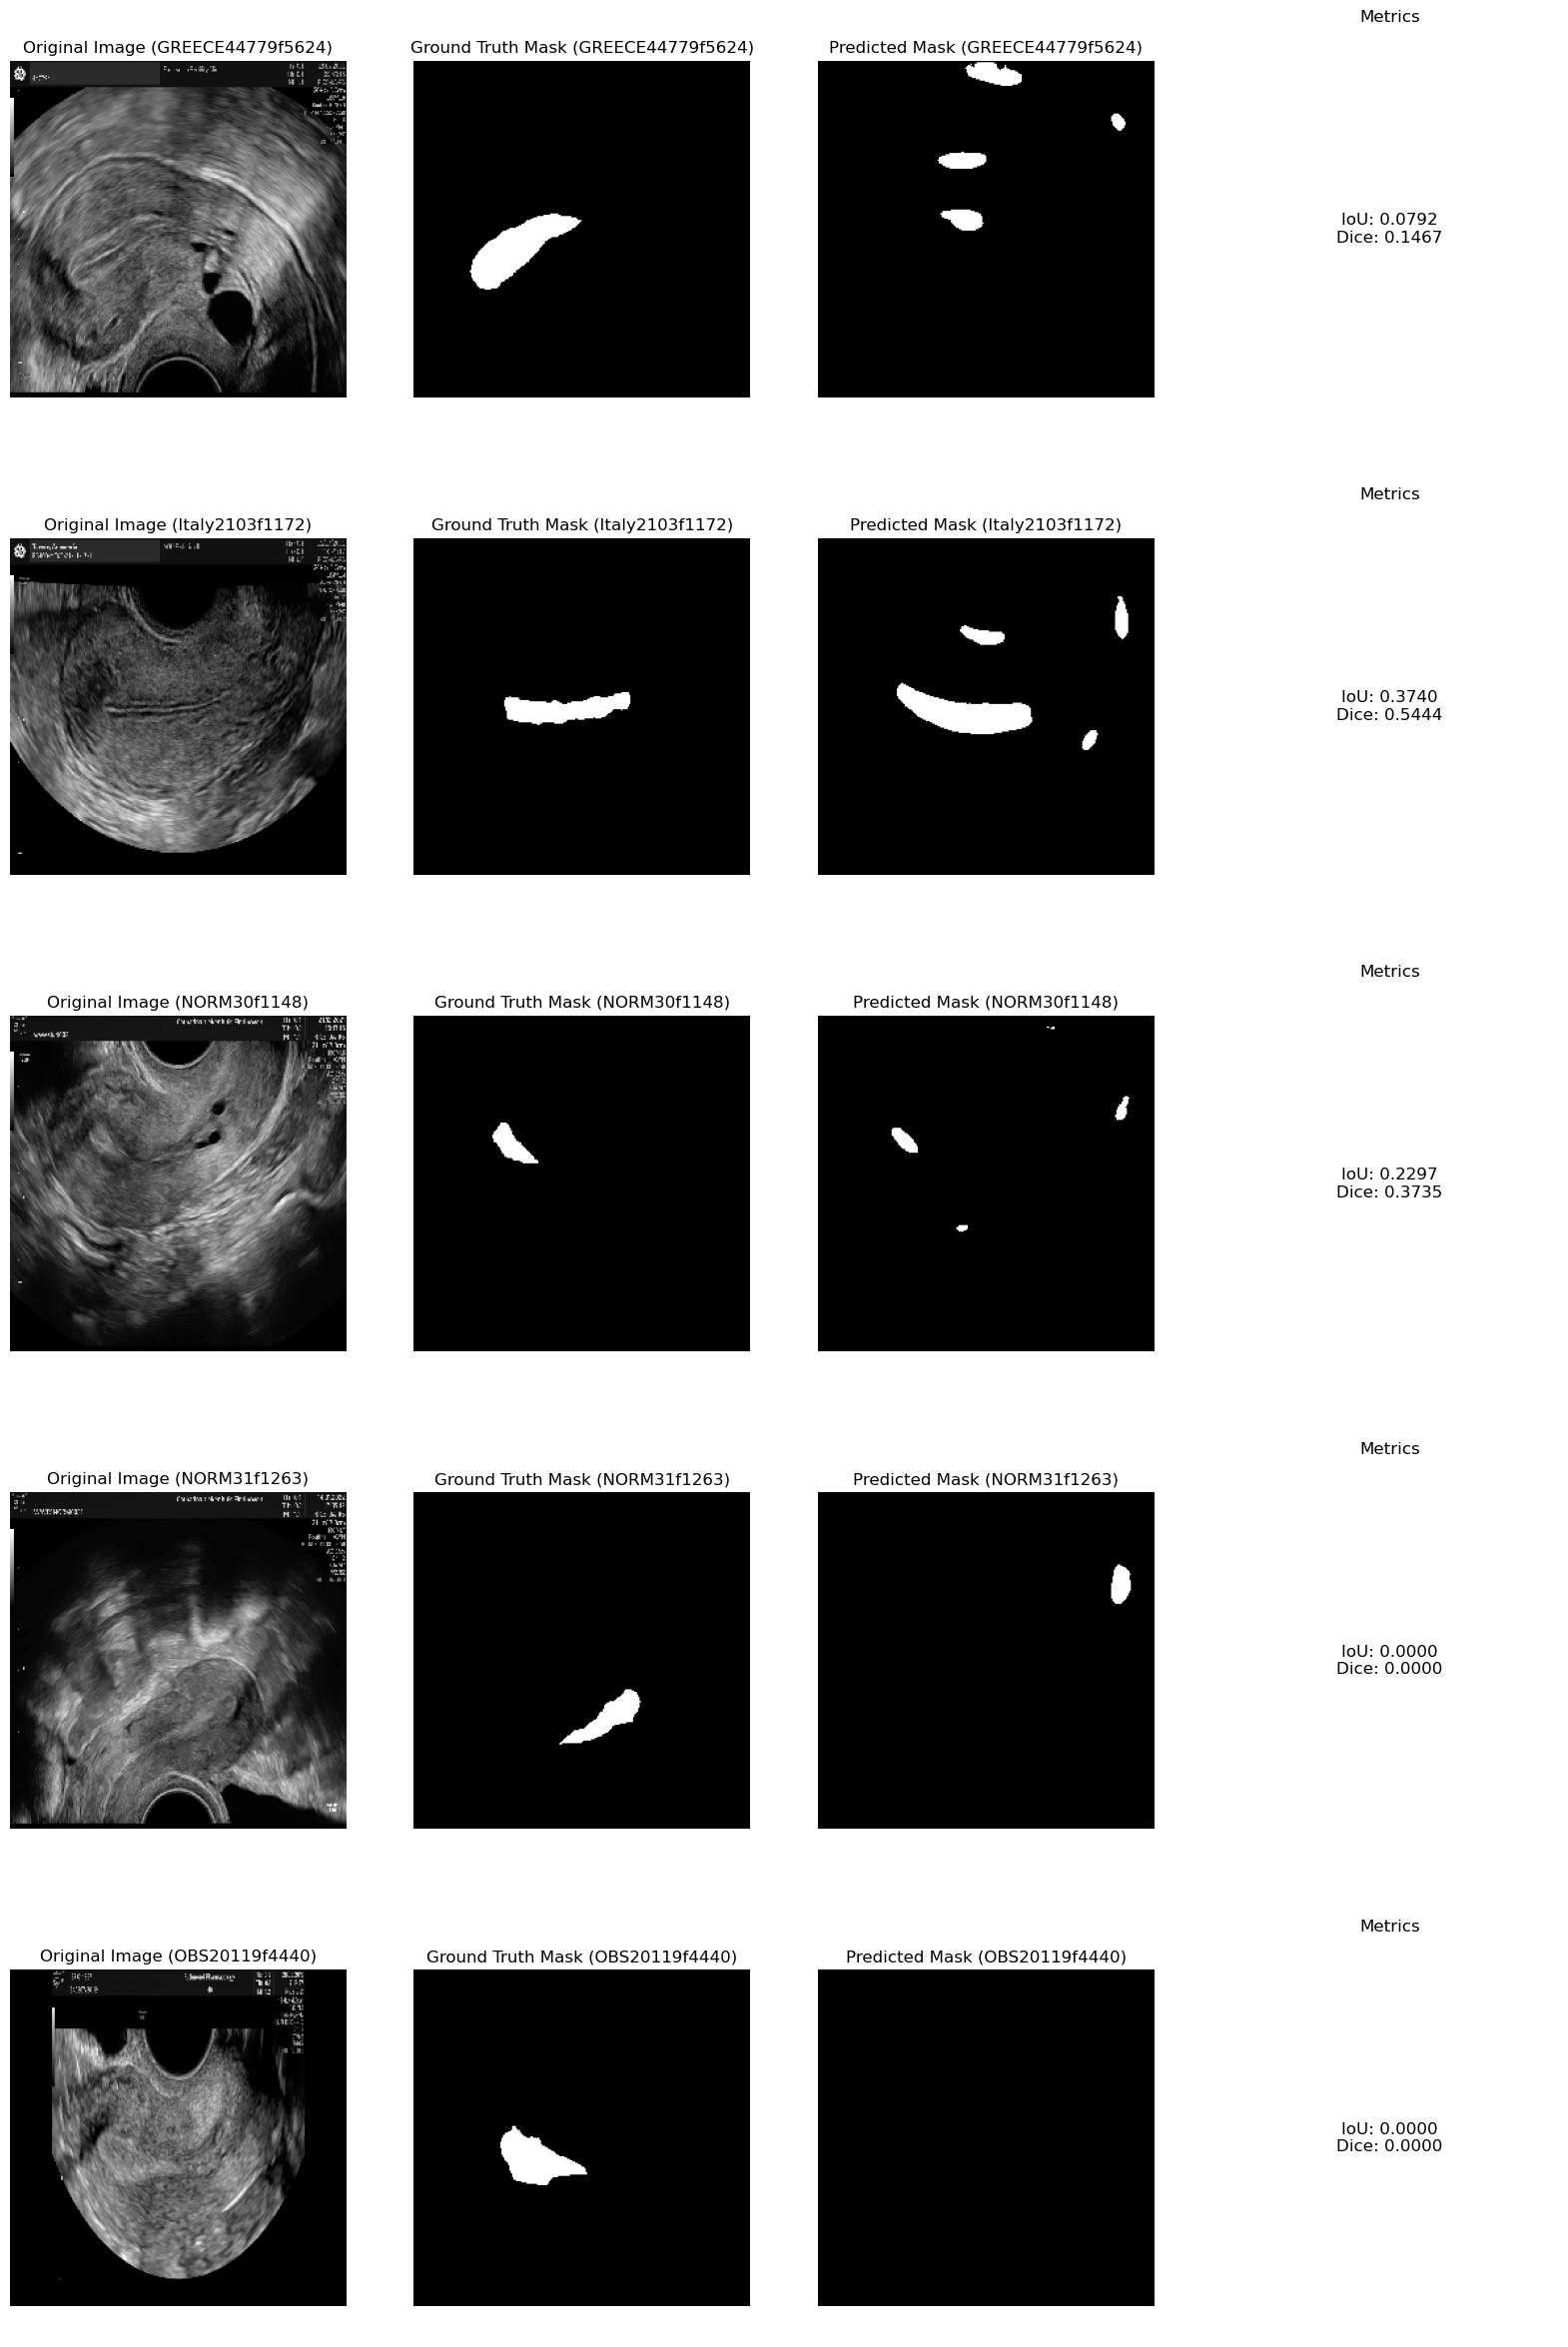

In [6]:
def display_images_with_metrics(images, masks, predictions, filenames, iou_scores, dice_scores, n=5):
    plt.figure(figsize=(20, n * 6))
    for i in range(n):
        # Original image
        plt.subplot(n, 4, i * 4 + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Original Image ({filenames[i]})")
        plt.axis("off")
        
        # Ground truth mask
        plt.subplot(n, 4, i * 4 + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title(f"Ground Truth Mask ({filenames[i]})")
        plt.axis("off")
        
        # Predicted mask
        plt.subplot(n, 4, i * 4 + 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title(f"Predicted Mask ({filenames[i]})")
        plt.axis("off")
        
        # IoU and Dice scores
        plt.subplot(n, 4, i * 4 + 4)
        plt.text(0.5, 0.5, f"IoU: {iou_scores[i]:.4f}\nDice: {dice_scores[i]:.4f}", 
                 horizontalalignment='center', verticalalignment='center', fontsize=12)
        plt.title("Metrics")
        plt.axis("off")
        
    plt.show()

display_images_with_metrics(test_images, test_masks, predicted_masks, filenames, iou_scores, dice_scores, n=5)
